In [208]:
import pandas as pd
import numpy as np

df = pd.read_csv("../May22/gc100-2.log", delim_whitespace=True)
df.head()

,nil,nil.1,timestamp,cpu,wall,ms,clock,cpu_time,ms_ignore,cpu_ignore,heap_size,mb_ignore,target,mb2_ignore,goal_ignore,cores,p_igore
0,gc,75,@531.059s,0%:,0.021+23+0.006,ms,"clock,",0.042+11/14/0+0.012,ms,"cpu,",13->13->7,"MB,",14,MB,"goal,",2,P
1,gc,76,@531.472s,0%:,9.8+43+0.006,ms,"clock,",19+18/19/0+0.013,ms,"cpu,",15->15->9,"MB,",16,MB,"goal,",2,P
2,gc,77,@532.556s,0%:,0.032+41+0.006,ms,"clock,",0.065+2.4/18/51+0.012,ms,"cpu,",18->18->8,"MB,",19,MB,"goal,",2,P
3,gc,78,@534.307s,0%:,0.10+126+0.004,ms,"clock,",0.21+52/82/9.8+0.009,ms,"cpu,",16->16->7,"MB,",17,MB,"goal,",2,P
4,gc,79,@535.876s,0%:,4.7+48+0.006,ms,"clock,",9.5+11/26/0.96+0.013,ms,"cpu,",14->14->7,"MB,",15,MB,"goal,",2,P


In [209]:
def split_cputime(cputime_raw):
    #
    prepare_time = []
    mutator_time = []
    background_time = []
    idle_time = []
    termination_time = []
    for t in cputime_raw:
        times = t.split('+')
        marking_times = times[1].split('/')
        prepare_time.append(times[0])
        termination_time.append(times[2])
        mutator_time.append(marking_times[0])
        background_time.append(marking_times[1])
        idle_time.append(marking_times[2])
        
    return pd.Series(prepare_time, dtype=float), pd.Series(mutator_time, dtype=float), pd.Series(background_time, dtype=float), pd.Series(idle_time, dtype=float), pd.Series(termination_time, dtype=float) 


def get_diff_timestamp(timestamps):
    intervals = [0] # placeholder for the first element
    for _, val in timestamps.items():
        val = val[0:-1]
        intervals.append(val[1:])

    
    np_arr = np.array(intervals, dtype=float)
    res = np.diff(np_arr)
    res[0] = 0.0 # reset the first element
    return pd.Series(res)


# def remove_first_elm(cpu_times):
#     sz = len(cpu_times)
# #     for i in range(sz):
# #         cpu_times[i] = cpu_times[i].iloc[1:]
        
#     return tuple(cpu_times[i].iloc[1:] for i in range(sz))

def zero_first_element(cpu_times):
    sz = len(cpu_times)
    for i in range(sz):
        cpu_times[i][0] = 0

        
def drop_first_element(cpu_times):
    sz = len(cpu_times)
    for i in range(sz):
        cpu_times[i].drop(labels=[0], inplace=True)

cores = df.cores[0]
cpu_times = split_cputime(df.cpu_time)
zero_first_element(cpu_times)
print(len(cpu_times), len(cpu_times[1]))

gc_internvals = get_diff_timestamp(df.timestamp)
print(len(gc_internvals))

5 65
65


In [210]:
frame = {'gc_interval': gc_internvals, 'prepare_time': cpu_times[0], 'assist_time': cpu_times[1], 'background_time': cpu_times[2], 'idle_time': cpu_times[3], 'termination_time': cpu_times[4]}
df_new = pd.DataFrame(frame)
df_new.head()

,gc_interval,prepare_time,assist_time,background_time,idle_time,termination_time
0,0.000,0.000,0.0,0.0,0.00,0.000
1,0.413,19.000,18.0,19.0,0.00,0.013
2,1.084,0.065,2.4,18.0,51.00,0.012
3,1.751,0.210,52.0,82.0,9.80,0.009
4,1.569,9.500,11.0,26.0,0.96,0.013


In [211]:
total = df_new.gc_interval.sum()
print("Total execution time: {:.2f}s".format(total))
gc_time = df_new.prepare_time.sum() + df_new.assist_time.sum() + df_new.background_time.sum() + df_new.idle_time.sum() + df_new.termination_time.sum()
gc_time_normalized = gc_time / cores
print("GC CPU time {:.2f}ms, normalized {:.2f}ms".format(gc_time, gc_time_normalized))
print("% of GC CPU over total: {:.2f}%".format(gc_time_normalized / (total * 1000) * 100)) # percentage
print("Prepare and Termination max time: {:.2f}ms, {:.2f}ms".format(df_new.prepare_time.max(), df_new.termination_time.max()))

Total execution time: 124.30s
GC CPU time 3868.17ms, normalized 1934.09ms
% of GC CPU over total: 1.56%
Prepare and Termination max time: 28.00ms, 0.94ms


In [212]:
gc_occurrances = len(gc_internvals) -1
gc_avg_time_normalized = gc_time_normalized / gc_occurrances
gc_avg_interval = total * 1000.0 / gc_occurrances
print("Average GC interval: {:.2f}ms".format(gc_avg_interval))
print("Average GC CPU time: {:.2f}ms".format(gc_avg_time_normalized))

Average GC interval: 1942.19ms
Average GC CPU time: 30.22ms


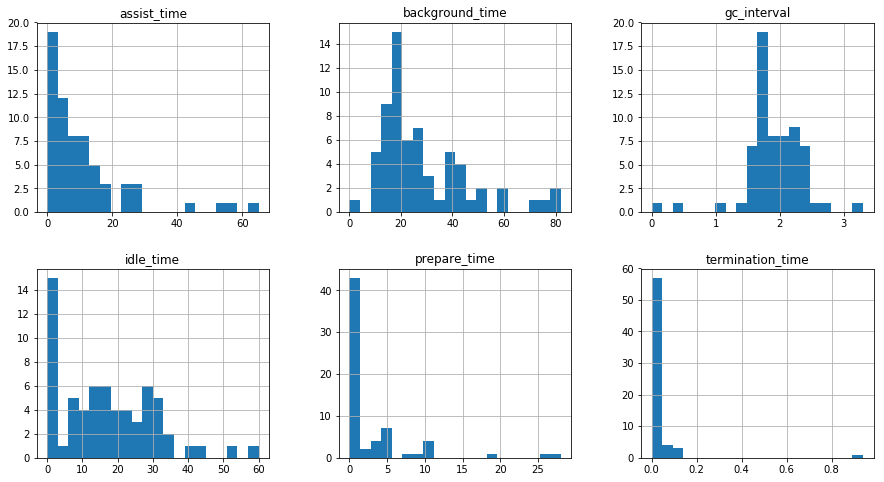

In [213]:
hist = df_new.hist(bins=20, layout=(2,3),figsize=(15,8))